In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pickle
from datetime import datetime

usingColab = True

# If using google colab change boolean above to True
if usingColab:
    from google.colab import drive
    drive.mount('/content/drive')

    # If using google colab change this path to the folder that this file is in make sure there is no slash on the end!!!
    %cd /content/drive/MyDrive/Msc Artificial Intelligence/Semester 1/Deep Neural Networks and Learning Systems/Assignment

# If you dont have the dataset set this to True although !wget only work in colab
downloadDataset = False

Mounted at /content/drive
/content/drive/MyDrive/Msc Artificial Intelligence/Semester 1/Deep Neural Networks and Learning Systems/Assignment


In [2]:
if downloadDataset and usingColab:
  fname = "./Dataset/kay_labels.npy"
  !wget -qO $fname https://osf.io/r638s/download

  fname = "./Dataset/kay_labels_val.npy"
  !wget -qO $fname https://osf.io/yqb3e/download

  fname = "./Dataset/kay_images.npz"
  !wget -qO $fname https://osf.io/ymnjv/download

In [3]:
# Loads dataset in as python dictionary
with np.load("./Dataset/kay_images.npz") as dobj:
    data = dict(**dobj)

# Loads the labels for the images in
labels = np.load('./Dataset/kay_labels.npy')
val_labels = np.load('./Dataset/kay_labels_val.npy')

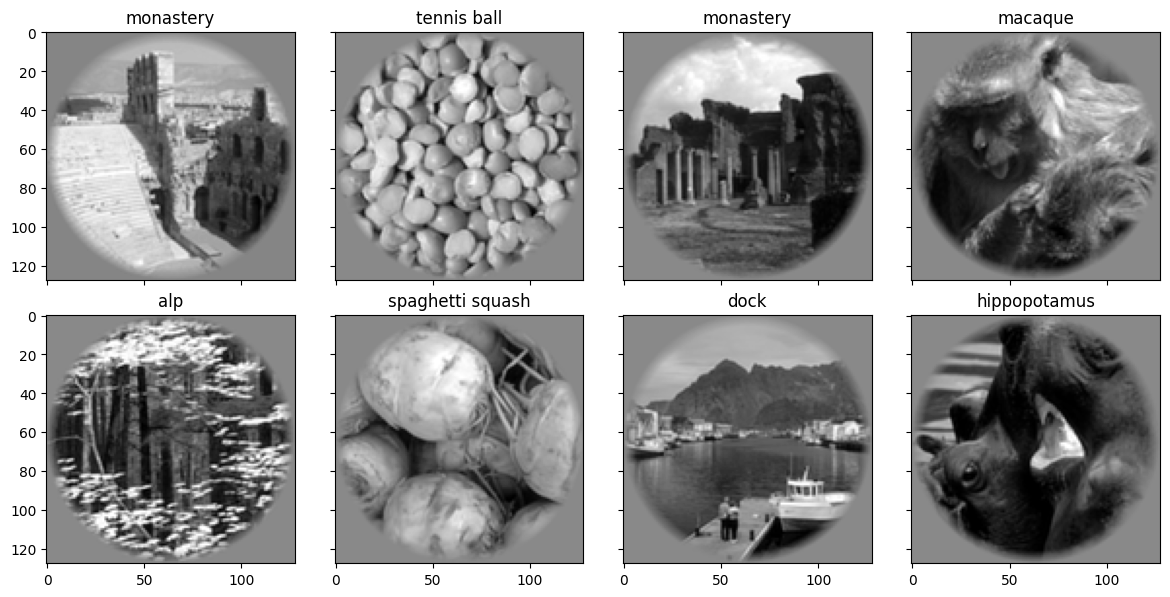

In [4]:
# Display some of the stimuli images with their labels
f, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for ax, im, lbl in zip(axs.flat, data["stimuli"][10:], labels[-1,10:]):
  ax.imshow(im, cmap="gray")
  ax.set_title(lbl)
f.tight_layout()

In [5]:
class CosineSimilarityLoss(nn.Module):
  # Custom loss function to use with model

  name = "cosine~similarity"

  def __init__(self):
    super(CosineSimilarityLoss, self).__init__()
    self.a = 0
    self.b = 0

  def forward(self, a, b):

    self.a = a
    self.b = b

    # Works out the cosine similarity between a batch of predictions and truths
    cos = torch.nn.CosineSimilarity(dim=1)
    similarity = cos(self.a, self.b)

    # Flips the cosine so -1 is a vector match to be compatible with gradient descent (adds 1 to make it 0 - 2 instead of -1 - 1)
    return torch.add(torch.mean(torch.multiply(similarity, -1)), 1)

In [6]:
# Loads all training and tset data from the data dictionary and formats for pytorch models
xTrainFull = torch.tensor(data['stimuli'].reshape(-1, 1, 128, 128), dtype=torch.float32)
yTrainFull = torch.tensor(data['responses'], dtype=torch.float32)

xTestFull = torch.tensor(data['stimuli_test'].reshape(-1, 1, 128, 128), dtype=torch.float32)
yTestFull = torch.tensor(data['responses_test'], dtype=torch.float32)

print(xTrainFull.size())
print(yTrainFull.size())
print(xTestFull.size())
print(yTestFull.size())

torch.Size([1750, 1, 128, 128])
torch.Size([1750, 8428])
torch.Size([120, 1, 128, 128])
torch.Size([120, 8428])


In [7]:
def modelLayerSummary(model):
# Creates a easy to read summary of the model for later evaluation
  modelSummary = {
      'summary': "",
      'convLayerTotal': 0,
      'convLayerTotalParams': 0,
      'linearLayerTotal': 0,
      'linearLayerTotalParams': 0,
  }

  for layer in model._modules.items():
    # print(layer)

    if type(layer[1]) == nn.modules.Conv2d:
      #print("This layers is conv2d")
      modelSummary['summary'] += layer[1].__str__() + "\n"
      modelSummary['convLayerTotalParams'] += layer[1].out_channels
      modelSummary['convLayerTotal'] += 1

    if type(layer[1]) == nn.modules.Linear:
      #print("This layers is linear")
      modelSummary['summary'] += layer[1].__str__() + "\n"
      modelSummary['linearLayerTotalParams'] +=  layer[1].in_features * layer[1].out_features
      modelSummary['linearLayerTotal'] += 1

    if type(layer[1]) == nn.modules.MaxPool2d:
      #print("This layers is pool")
      modelSummary['summary'] += layer[1].__str__() + "\n"

  return modelSummary

In [8]:
def saveModel (model, modelLogs, fileNameAdditions = ""):
  # Saves the model with a name matching its parameters as well as logs of its loss and accuracy curves during training

  summary = modelLayerSummary(model)

  modelName = f"{summary['convLayerTotal']}({summary['convLayerTotalParams']})-{summary['linearLayerTotal']}({summary['linearLayerTotalParams']})-{modelLogs['optimizer']}-{modelLogs['learningrate']}-{modelLogs['lossfunction']}-{modelLogs['epochs']}-{modelLogs['batchsize']}-{modelLogs['finalTrainingAccuracy']}-{modelLogs['finalValidationAccuracy']}"

  if fileNameAdditions != "":
    modelName += f"-{fileNameAdditions}"

  folderPath = f"./models/{modelName}-{datetime.now().strftime('%d %m %Y.%H %M %S')}/"

  if not os.path.exists(folderPath):
    os.makedirs(folderPath)

  torch.save(model, f"{folderPath}model.pt")

  with open(f'{folderPath}summaryDictionary.pkl', 'wb') as f:
    pickle.dump(summary, f)

  with open(f'{folderPath}logs.pkl', 'wb') as f:
    pickle.dump(modelLogs, f)

  with open(f'{folderPath}modelSummary.txt', 'w') as f:
    f.write(summary['summary'])

  print(f"Model Saved to '{folderPath}'")


In [9]:
def loadModel(folderPath):
  # Loads a model and its logs from a folder path

  with open(f'{folderPath}summaryDictionary.pkl', 'rb') as f:
    summary = pickle.load(f)

  with open(f'{folderPath}logs.pkl', 'rb') as f:
    modelLogs = pickle.load(f)

  model = torch.load(f'{folderPath}model.pt', 'cuda' if torch.cuda.is_available() else 'cpu')

  return model, modelLogs, summary

In [11]:
# Evaluates a model on some test data
def evaluateModel(model, x, y):

  model.eval()

  yPred = model.forward(x)

  cos = torch.nn.CosineSimilarity(dim=1)
  similarity = cos(yPred, y)

  # Works out the mean accuracy of the test data as a percentage between 0 - 2
  accuracy = torch.divide(torch.add(torch.mean(similarity), 1), 2)

  return accuracy

In [10]:
def TrainModel(model, data, optimizer, criterion, modelLogs, fileNameAdditions = ""):
  # Trains a model on a some data

  # Grabs predfined variables for amount of epochs and batchsize
  epochs = modelLogs['epochs']
  batchSize = modelLogs['batchsize']

  # Splits input data into training and test splits
  xTrain, yTrain, xTest, yTest = data

  # Sends data to gpu or cpu depending on whats available
  model = model.to(modelLogs['device'])
  xTrain = xTrain.to(modelLogs['device'])
  yTrain = yTrain.to(modelLogs['device'])
  xTest = xTest.to(modelLogs['device'])
  yTest = yTest.to(modelLogs['device'])

  # Loops for an amount of epochs
  for i in range(epochs):

    model.train()
    # Loops round the training data in an interval of batchSize (usually 128)
    for index in range(0, xTrain.size()[0], batchSize):

      # Splits the batch and labels
      batch = xTrain[index:min(index + batchSize, xTrain.size()[0]), :]
      y = yTrain[index:min(index + batchSize, yTrain.size()[0]), :]

      # Sends the batch of images through the model in a forward pass
      yPred = model.forward(batch)

      # Computes the loss
      loss = criterion.forward(yPred, y)

      # updates weights using back propgation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # Sends model to be evaluated after every epoch to track improvment on test data
    valAcc = evaluateModel(model, xTest, yTest)

    # Save current training performance values to logs
    modelLogs['validation'].append(valAcc.item()*100)
    modelLogs['training'].append(((2 - loss.item()) / 2) * 100)
    modelLogs['loss'].append(loss.item())

    # Print the loss, training and validation accuracy every epoch
    print(f"Epoch {i} loss: {loss.item()} training accuracy: {((2 - loss) / 2) * 100} validation accuracy: {valAcc * 100}")

  print("Training Complete!!!\n")

  # Save the final training and validation accuracy for model logs
  modelLogs['finalTrainingAccuracy'] = round(((2 - loss.detach().item()) / 2) * 100, 2)
  modelLogs['finalValidationAccuracy'] = round(valAcc.detach().item() * 100, 2)

  # Save the model
  saveModel(model, modelLogs, fileNameAdditions)

All of these network classes are interchanged for the testing of different model structures and hyper parameters
The first class defined is the base model

In [15]:
# Base model
class FullNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 30 * 30, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8428)

    def forward(self, x):
        x = self.pool(F.relu(self.input(x)))
        #print(x.size())

        x = self.pool(F.relu(self.conv1(x)))
        #print(x.size())

        x = torch.flatten(x, 1)
        #print(x.size())
        x = F.relu(self.fc1(x))

        x = F.relu(self.fc2(x))

        return self.fc3(x)

In [ ]:
# Small amount of feature maps
class FullNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Conv2d(1, 2, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(2, 5, 3)
        self.fc1 = nn.Linear(5 * 30 * 30, 8)
        #self.fc2 = nn.Linear(1028, 8428)

        self.fc2 = nn.Linear(8, 8428)

    def forward(self, x):
        x = self.pool(F.relu(self.input(x)))
        #print(x.size())

        x = self.pool(F.relu(self.conv1(x)))
        #print(x.size())

        x = torch.flatten(x, 1)
        #print(x.size())

        drop = nn.Dropout(p=0.5)
        x = drop(F.relu(self.fc1(x)))

        #x = F.relu(self.fc1(x))

        return self.fc2(x)

In [ ]:
# Wide model
class FullNetwork(nn.Module):

  def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, 6, 5)
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(6, 16, 5)
      self.fc1 = nn.Linear(16 * 29 * 29, 1024)
      self.fc2 = nn.Linear(1024, 2048)
      self.fc3 = nn.Linear(2048, 8428)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch

    drop = nn.Dropout(p=0.5)
    x = drop(F.relu(self.fc1(x)))

    drop = nn.Dropout(p=0.7)
    x = drop(F.relu(self.fc2(x)))

    x = self.fc3(x)
    return x

In [ ]:
# Lots of convolutional feature maps
class FullNetwork(nn.Module):

  def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, 6, 5)
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(6, 16, 5)
      self.conv3 = nn.Conv2d(16, 32, 5)
      self.conv4 = nn.Conv2d(32, 64, 5)
      self.fc1 = nn.Linear(64 * 21 * 21, 32)
      self.fc2 = nn.Linear(32, 32)
      self.fc3 = nn.Linear(32, 8428)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    drop = nn.Dropout(p=0.2)
    x = drop(F.relu(self.fc1(x)))
    drop = nn.Dropout(p=0.3)
    x = drop(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x

In [ ]:
# Lots of convolutions without dropout
class FullNetwork(nn.Module):

  def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, 6, 5)
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(6, 16, 5)
      self.conv3 = nn.Conv2d(16, 32, 5)
      self.conv4 = nn.Conv2d(32, 64, 5)
      self.fc1 = nn.Linear(64 * 21 * 21, 64)
      self.fc2 = nn.Linear(64, 64)
      self.fc3 = nn.Linear(64, 8428)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    #print(x.size())
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [13]:
# Displays a current summary of the loaded network class
net = FullNetwork()

print(modelLayerSummary(net)["summary"])
print(modelLayerSummary(net)["linearLayerTotalParams"])
print(modelLayerSummary(net)["convLayerTotalParams"])

Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
Linear(in_features=14400, out_features=120, bias=True)
Linear(in_features=120, out_features=84, bias=True)
Linear(in_features=84, out_features=8428, bias=True)

2446032
22


In [14]:
# Sets parameters for model to train with
epochs = 1
batchSize = 128
learningRate = 0.001

# Defines model loss and optimizer
modelFull = FullNetwork()
criterion = CosineSimilarityLoss()
optimizer =  torch.optim.Adam(modelFull.parameters(), lr=learningRate, weight_decay=0.001)
#optimizer = torch.optim.Adam(modelFull.parameters(), lr=learningRate)

# Sets up model log dictionary to save training data to and grab parameters for training
modelLogs = {
    'batchsize': batchSize,
    'epochs' : epochs,
    'learningrate': learningRate,
    'lossfunction': criterion.name,
    'optimizer': optimizer.__class__.__name__,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'validation': [],
    'training': [],
    'loss': [],
    'finalTrainingAccuracy': 0.0,
    'finalValidationAccuracy': 0.0
}

# Trains model
TrainModel(modelFull, [xTrainFull, yTrainFull, xTestFull, yTestFull], optimizer, criterion, modelLogs, "")

Epoch 0 loss: 1.005063772201538 training accuracy: 49.74681091308594 validation accuracy: 50.369625091552734
Training Complete!!!

Model Saved to './models/2(22)-3(2446032)-Adam-0.001-cosine~similarity-1-128-49.75-50.37-05 01 2024.11 37 44/'


In [ ]:
# Training setup used before the functions above were created
epochs = 10
batchSize = 64
learningRate = 0.001

modelFull = FullNetwork()
criterion = CosineSimilarityLoss()
#optimizer =  torch.optim.Adam(modelFull.parameters(), lr=learningRate, weight_decay=0.0001)
optimizer = torch.optim.Adam(modelFull.parameters(), lr=learningRate)

modelLogs = {
    'batchsize': batchSize,
    'epochs' : epochs,
    'learningrate': learningRate,
    'lossfunction': criterion.name,
    'optimizer': optimizer.__class__.__name__,
    'validation': [],
    'training': [],
    'loss': []
}

for i in range(epochs):

  modelFull.train()
  for index in range(0, xTrainFull.size()[0], batchSize):

    batch = xTrainFull[index:min(index + batchSize, xTrainFull.size()[0]), :]
    y = yTrainFull[index:min(index + batchSize, xTrainFull.size()[0]), :]

    modelFull.forward(batch)

    yPred = modelFull.forward(batch)

    loss = criterion.forward(yPred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  valAcc = evaluateModel(modelFull, xTestFull, yTestFull)

  modelLogs['validation'].append(valAcc.item()*100)
  modelLogs['training'].append(((2 - loss.item()) / 2) * 100)
  modelLogs['loss'].append(loss.item())

  print(f"Epoch {i} loss: {loss.item()} training accuracy: {((2 - loss) / 2) * 100} validation accuracy: {valAcc * 100}")

KeyboardInterrupt: 

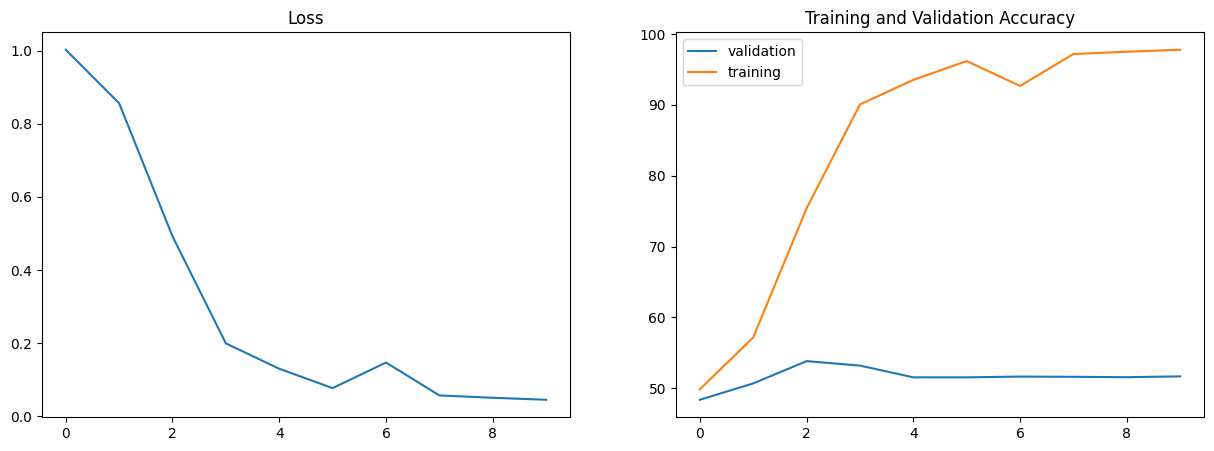

In [ ]:
# Displays a models performance after training (this only works on the older training loop please refer to the model evaluation file to see updated graphs)
fig = plt.figure(figsize=(15, 5))

fig.subplots_adjust(wspace=0.2, hspace=1.0)

s1 = fig.add_subplot(1, 2, 1)
s1.set_title("Loss")
s1.plot(np.arange(modelLogs['epochs']), modelLogs['loss'])

s2 = fig.add_subplot(1, 2, 2)
s2.set_title("Training and Validation Accuracy")
s2.plot(np.arange(modelLogs['epochs']), modelLogs['validation'], label = "validation")
s2.plot(np.arange(modelLogs['epochs']), modelLogs['training'], label = "training")

s2.legend(loc="best")

In [ ]:
# Old model evaluation code
modelFull.eval()
with torch.no_grad():
  result = modelFull.forward(xTestFull[:1])

print(yTestFull[0])
print(result[0])

print(np.dot(result[0], yTestFull[0]) / (np.linalg.norm(result[0]) * np.linalg.norm(yTestFull[0])))

tensor([-0.1252, -0.1735,  0.7785,  0.1220, -0.1699,  0.1774, -0.3636,  0.1539,
         0.7343,  0.2863,  0.3059, -0.6408,  0.6107, -0.2768,  0.3845, -0.3571,
         0.5699,  0.2193, -0.6470, -0.2047,  0.0952, -0.1407, -0.7962, -0.1083,
        -0.1125,  0.9467, -0.2041,  0.2164, -0.7837, -0.4237,  0.2962,  0.6329,
        -0.5477, -0.3060,  0.1328,  0.1992, -0.1143,  0.6761,  0.6157, -0.1647,
         0.2583, -0.2365,  0.1611,  0.2888,  0.1434,  0.4107,  0.8273,  0.3156,
         0.2583,  1.0163,  0.3722,  0.1396,  0.1640, -0.0129,  1.1075,  0.2566,
         0.5287,  0.2639, -0.0843, -0.7865,  0.1270,  0.4227, -0.1187, -0.2394,
         0.5848, -0.1279, -0.1191,  0.1080, -0.3526, -0.1023, -0.0224,  0.1854,
         0.4322, -0.3455,  0.7093,  0.0141, -0.8385, -1.2696,  0.8331, -0.6241,
        -0.5070,  0.1945, -0.1541,  0.2693, -0.3565, -0.1311, -0.3535, -0.5277,
        -0.3010, -0.2610, -0.8192, -1.2411, -0.5745, -0.0581, -0.3643, -0.1203,
         0.8608,  0.6404, -0.5972,  0.05